# Import Library

In [1]:
import os
import json

import numpy as np

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2

In [2]:
data_dir = "C:\\Users\\eliza\\clinico-medical-chatbot-v2\\data\\skin_dataset"
print(os.listdir(data_dir))

['test_set', 'train_set']


In [3]:
tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1157 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Inspect Data

(205, 205, 3)


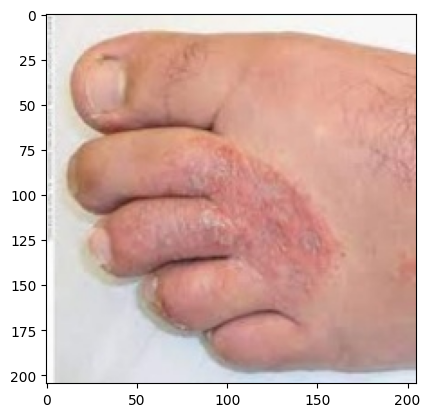

In [4]:
base_dir = r"C:/Users/eliza/clinico-medical-chatbot-v2/data/skin_dataset/train_set"

image_path = os.path.join(
    base_dir,
    "FU-athlete-foot",
    "FU-athlete-foot (1).jpeg"
)

img=mpimg.imread(image_path)
print(img.shape)

plt.imshow(img)
plt.axis()
plt.show()

# Data Preposcessing

In [14]:
img_size = 224
batch_size = 32

train_val_dir = "C:/Users/eliza/clinico-medical-chatbot-v2/data/skin_dataset/train_set"
test_dir = "C:/Users/eliza/clinico-medical-chatbot-v2/data/skin_dataset/test_set"

def resize_and_pad(img):
    desired_size = 224
    old_size = img.shape[:2]  

    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    img = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(
        img,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )
    
    return padded_img / 255.0

train_datagen = ImageDataGenerator(
    preprocessing_function=resize_and_pad,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.25
)

train_gen = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    interpolation='bilinear',
    shuffle=True
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=resize_and_pad,
    validation_split=0.25
)

valid_gen = valid_datagen.flow_from_directory(
    train_val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    interpolation='bilinear',
    shuffle=False
)

test_datagen = ImageDataGenerator(
    preprocessing_function=resize_and_pad
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    interpolation='bilinear',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
print("Train samples:", train_gen.samples)
print("Validation samples:", valid_gen.samples)
print("Test samples:", test_gen.samples)

Found 695 images belonging to 8 classes.
Found 229 images belonging to 8 classes.
Found 233 images belonging to 8 classes.
Class indices: {'BA- cellulitis': 0, 'BA-impetigo': 1, 'FU-athlete-foot': 2, 'FU-nail-fungus': 3, 'FU-ringworm': 4, 'PA-cutaneous-larva-migrans': 5, 'VI-chickenpox': 6, 'VI-shingles': 7}
Train samples: 695
Validation samples: 229
Test samples: 233


In [15]:
MODEL_DIR = "C:/Users/eliza/clinico-medical-chatbot-v2/models"
CLASS_JSON_PATH = os.path.join(MODEL_DIR, "class_names.json")

os.makedirs(MODEL_DIR, exist_ok=True)

with open(CLASS_JSON_PATH, "w") as f:
    json.dump(train_gen.class_indices, f, indent=4)

print(f"class_names.json saved to {CLASS_JSON_PATH}")

class_names.json saved to C:/Users/eliza/clinico-medical-chatbot-v2/models\class_names.json


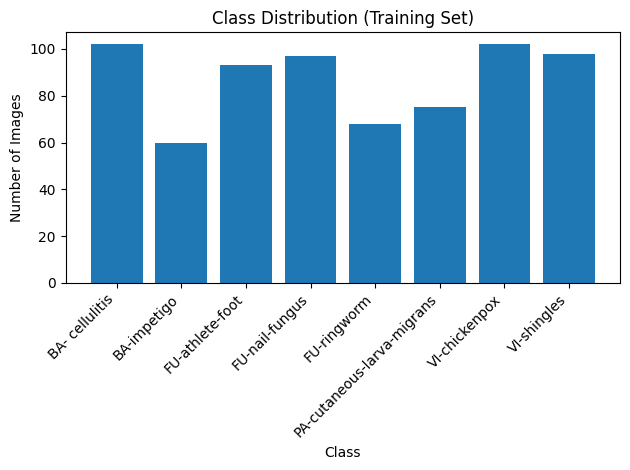

In [16]:
class_names = list(train_gen.class_indices.keys())

class_counts = np.bincount(train_gen.classes)

plt.figure()
plt.bar(class_names, class_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution (Training Set)")
plt.tight_layout()
plt.show()

## Handling class imbalance

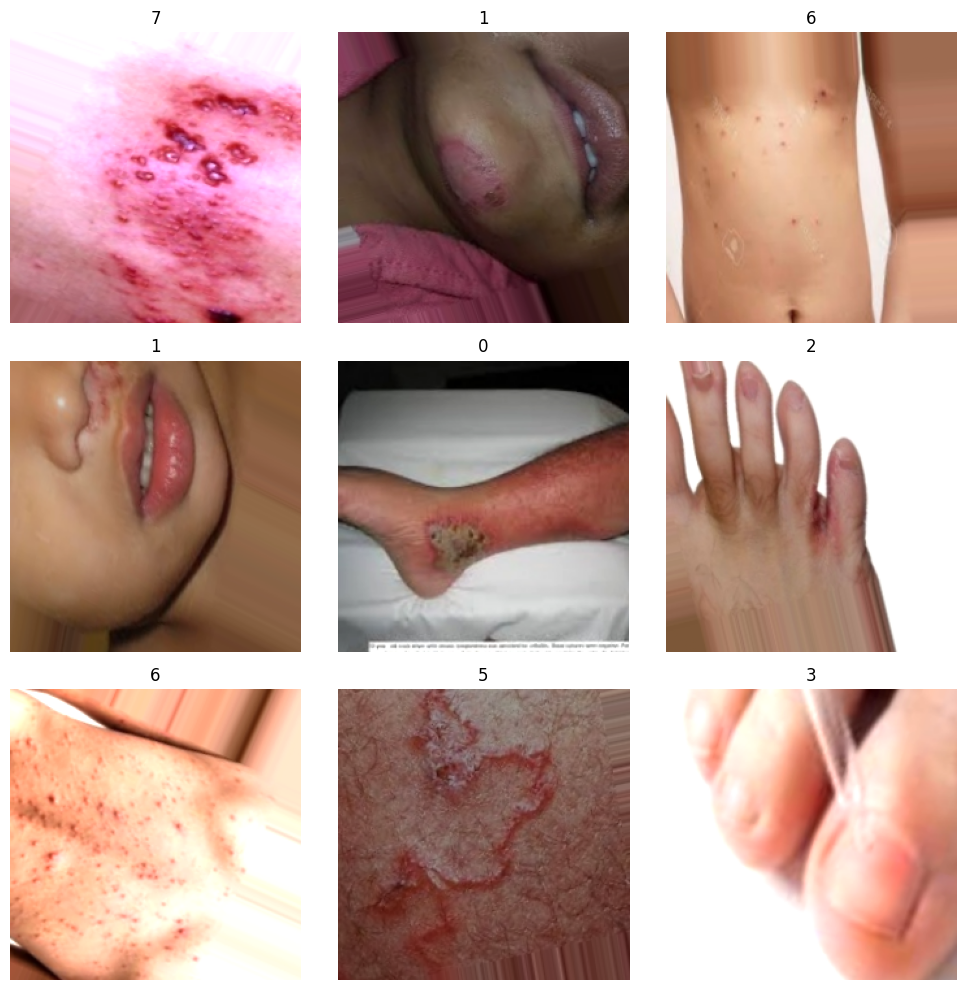

In [17]:
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

# Transfer Learning 

In [9]:
base_model = ResNet152V2(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 58,858,248
Trainable params: 526,600
Non-trainable params: 58,331,648
______________________________________

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [16]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1
)

In [17]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/15
22/22 [==============================] - 98s 4s/step - loss: 1.1985 - accuracy: 0.6000 - val_loss: 0.4969 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 2/15
22/22 [==============================] - 81s 4s/step - loss: 0.5547 - accuracy: 0.8173 - val_loss: 0.3788 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 3/15
22/22 [==============================] - 84s 4s/step - loss: 0.3604 - accuracy: 0.8763 - val_loss: 0.2921 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 4/15
22/22 [==============================] - 84s 4s/step - loss: 0.2803 - accuracy: 0.8863 - val_loss: 0.2283 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 5/15
22/22 [==============================] - 84s 4s/step - loss: 0.2429 - accuracy: 0.9266 - val_loss: 0.1805 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 6/15
22/22 [==============================] - 85s 4s/step - loss: 0.1867 - accuracy: 0.9439 - val_loss: 0.2545 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 7/15
22/22 [==============================] - 84s 4s/step - loss: 0.2119 - a

# Evaluate Model

In [18]:
print("Evaluating model on test data........")

test_loss, test_accuracy = model.evaluate(
    test_gen,
    steps=test_gen.samples // batch_size
)

print(f"Test accuracy: {test_accuracy*100:.2f}%")

Evaluating model on test data........
7/7 [==============================] - 19s 3s/step - loss: 0.2816 - accuracy: 0.9196
Test accuracy: 91.96%


In [19]:
Y_true = valid_gen.classes
Y_pred = np.argmax(model.predict(valid_gen), axis=1)

print(classification_report(Y_true, Y_pred, target_names=valid_gen.class_indices.keys()))

8/8 [==============================] - 21s 2s/step
                            precision    recall  f1-score   support

            BA- cellulitis       1.00      0.91      0.95        33
               BA-impetigo       0.95      0.95      0.95        20
           FU-athlete-foot       0.97      0.90      0.93        31
            FU-nail-fungus       0.91      0.97      0.94        32
               FU-ringworm       0.88      0.95      0.91        22
PA-cutaneous-larva-migrans       0.86      0.96      0.91        25
             VI-chickenpox       0.97      1.00      0.99        34
               VI-shingles       1.00      0.91      0.95        32

                  accuracy                           0.94       229
                 macro avg       0.94      0.94      0.94       229
              weighted avg       0.95      0.94      0.94       229



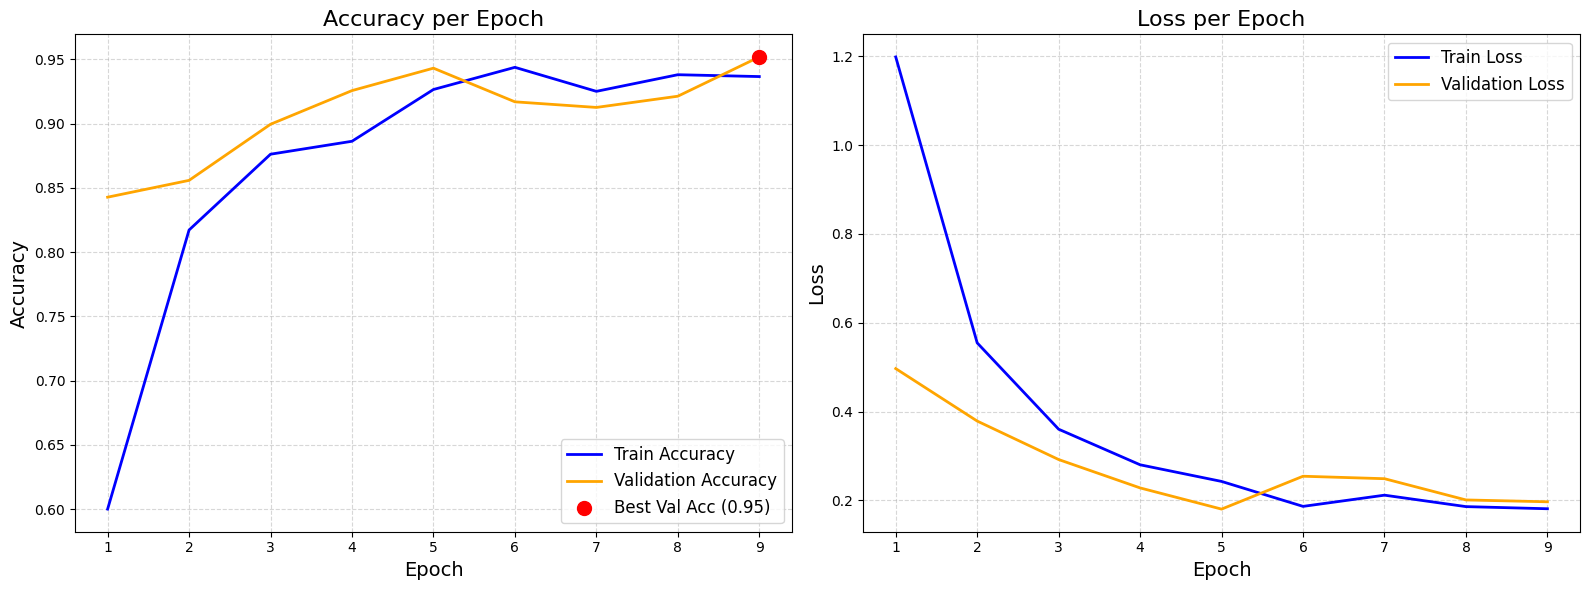

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Cari epoch terbaik
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# ----- Accuracy -----
axes[0].plot(epochs, train_acc, label='Train Accuracy', color='blue', linewidth=2)
axes[0].plot(epochs, val_acc, label='Validation Accuracy', color='orange', linewidth=2)
axes[0].scatter(best_epoch+1, best_val_acc, color='red', s=100, zorder=5, label=f'Best Val Acc ({best_val_acc:.2f})')
axes[0].set_title('Accuracy per Epoch', fontsize=16)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# ----- Loss -----
axes[1].plot(epochs, train_loss, label='Train Loss', color='blue', linewidth=2)
axes[1].plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)
axes[1].set_title('Loss per Epoch', fontsize=16)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Saving the Model

In [ ]:
# model.save("skin_disease_resnet152v2.keras")